##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with an LSTM

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c08_forecasting_with_lstm.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

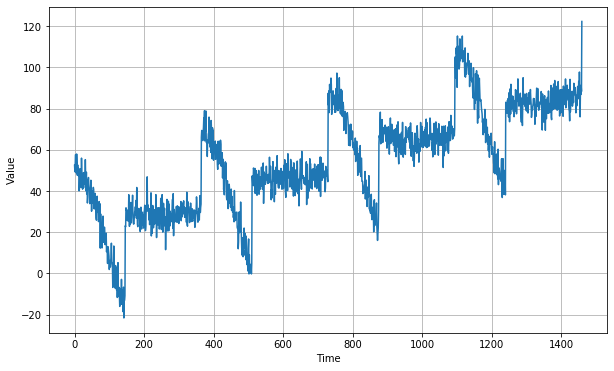

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 3s 76ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 13ms/step - loss: 83.8978 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 0s 13ms/step - loss: 75.4974 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 66.0676 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 55.5131 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 43.7599 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 30.7909 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 17.1478 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 0s 13ms/step - loss: 10.0311 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 0s 14ms/step - loss: 10.0607 - mae: 10.5524
Epoch 11/100
33/33 [=========

33/33 [==============================] - 0s 15ms/step - loss: 23.0193 - mae: 23.5173
Epoch 86/100
33/33 [==============================] - 0s 14ms/step - loss: 18.8522 - mae: 19.3444
Epoch 87/100
33/33 [==============================] - 0s 13ms/step - loss: 17.4332 - mae: 17.9281
Epoch 88/100
33/33 [==============================] - 0s 14ms/step - loss: 34.0078 - mae: 34.5063
Epoch 89/100
33/33 [==============================] - 0s 15ms/step - loss: 33.6064 - mae: 34.1014
Epoch 90/100
33/33 [==============================] - 0s 15ms/step - loss: 28.2173 - mae: 28.7150
Epoch 91/100
33/33 [==============================] - 0s 14ms/step - loss: 34.6979 - mae: 35.1959
Epoch 92/100
33/33 [==============================] - 0s 14ms/step - loss: 31.6628 - mae: 32.1619
Epoch 93/100
33/33 [==============================] - 0s 14ms/step - loss: 29.9807 - mae: 30.4743
Epoch 94/100
33/33 [==============================] - 0s 15ms/step - loss: 35.3540 - mae: 35.8523
Epoch 95/100
33/33 [=============

[1e-08, 0.0001, 0, 30]

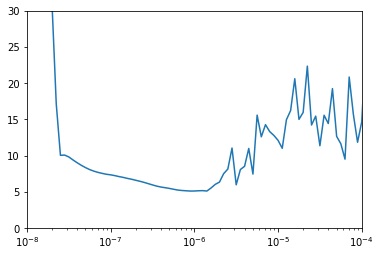

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 3s 92ms/step - loss: 30.0122 - mae: 30.5051 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 1s 18ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 19ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 17ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 17ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 1s 

33/33 [==============================] - 1s 18ms/step - loss: 4.8800 - mae: 5.3581 - val_loss: 7.7570 - val_mae: 8.2442
Epoch 63/500
33/33 [==============================] - 1s 18ms/step - loss: 4.8741 - mae: 5.3520 - val_loss: 7.7333 - val_mae: 8.2205
Epoch 64/500
33/33 [==============================] - 1s 18ms/step - loss: 4.8722 - mae: 5.3498 - val_loss: 7.6966 - val_mae: 8.1836
Epoch 65/500
33/33 [==============================] - 1s 18ms/step - loss: 4.8715 - mae: 5.3490 - val_loss: 7.6494 - val_mae: 8.1360
Epoch 66/500
33/33 [==============================] - 1s 18ms/step - loss: 4.8703 - mae: 5.3477 - val_loss: 7.5974 - val_mae: 8.0836
Epoch 67/500
33/33 [==============================] - 1s 18ms/step - loss: 4.8670 - mae: 5.3447 - val_loss: 7.5479 - val_mae: 8.0336
Epoch 68/500
33/33 [==============================] - 1s 18ms/step - loss: 4.8605 - mae: 5.3386 - val_loss: 7.5021 - val_mae: 7.9872
Epoch 69/500
33/33 [==============================] - 1s 17ms/step - loss: 4.8501 

33/33 [==============================] - 1s 17ms/step - loss: 4.5730 - mae: 5.0497 - val_loss: 6.3983 - val_mae: 6.8797
Epoch 124/500
33/33 [==============================] - 1s 17ms/step - loss: 4.5804 - mae: 5.0580 - val_loss: 6.3480 - val_mae: 6.8288
Epoch 125/500
33/33 [==============================] - 1s 19ms/step - loss: 4.5903 - mae: 5.0683 - val_loss: 6.2881 - val_mae: 6.7686
Epoch 126/500
33/33 [==============================] - 1s 19ms/step - loss: 4.5975 - mae: 5.0763 - val_loss: 6.2285 - val_mae: 6.7080
Epoch 127/500
33/33 [==============================] - 1s 18ms/step - loss: 4.6012 - mae: 5.0805 - val_loss: 6.1630 - val_mae: 6.6413
Epoch 128/500
33/33 [==============================] - 1s 17ms/step - loss: 4.6009 - mae: 5.0804 - val_loss: 6.1096 - val_mae: 6.5877
Epoch 129/500
33/33 [==============================] - 1s 17ms/step - loss: 4.5966 - mae: 5.0763 - val_loss: 6.0684 - val_mae: 6.5466
Epoch 130/500
33/33 [==============================] - 1s 17ms/step - loss: 

33/33 [==============================] - 1s 17ms/step - loss: 4.4778 - mae: 4.9560 - val_loss: 5.8717 - val_mae: 6.3484
Epoch 185/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4721 - mae: 4.9500 - val_loss: 5.8624 - val_mae: 6.3390
Epoch 186/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4672 - mae: 4.9448 - val_loss: 5.8582 - val_mae: 6.3346
Epoch 187/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4631 - mae: 4.9402 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 188/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4601 - mae: 4.9368 - val_loss: 5.8563 - val_mae: 6.3326
Epoch 189/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4579 - mae: 4.9344 - val_loss: 5.8563 - val_mae: 6.3327
Epoch 190/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4564 - mae: 4.9328 - val_loss: 5.8560 - val_mae: 6.3323
Epoch 191/500
33/33 [==============================] - 1s 17ms/step - loss: 

33/33 [==============================] - 1s 16ms/step - loss: 4.3984 - mae: 4.8756 - val_loss: 5.6014 - val_mae: 6.0797
Epoch 246/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4098 - mae: 4.8861 - val_loss: 5.9079 - val_mae: 6.3862
Epoch 247/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3922 - mae: 4.8693 - val_loss: 5.5531 - val_mae: 6.0320
Epoch 248/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4200 - mae: 4.8965 - val_loss: 5.6921 - val_mae: 6.1698
Epoch 249/500
33/33 [==============================] - 1s 16ms/step - loss: 4.4039 - mae: 4.8805 - val_loss: 5.8601 - val_mae: 6.3379
Epoch 250/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3943 - mae: 4.8716 - val_loss: 5.5772 - val_mae: 6.0558
Epoch 251/500
33/33 [==============================] - 1s 17ms/step - loss: 4.4064 - mae: 4.8827 - val_loss: 5.9061 - val_mae: 6.3849
Epoch 252/500
33/33 [==============================] - 1s 17ms/step - loss: 

33/33 [==============================] - 1s 16ms/step - loss: 4.3872 - mae: 4.8655 - val_loss: 5.6910 - val_mae: 6.1721
Epoch 307/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3592 - mae: 4.8360 - val_loss: 5.4077 - val_mae: 5.8886
Epoch 308/500
33/33 [==============================] - 1s 18ms/step - loss: 4.3585 - mae: 4.8331 - val_loss: 5.4354 - val_mae: 5.9166
Epoch 309/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3449 - mae: 4.8200 - val_loss: 5.2696 - val_mae: 5.7506
Epoch 310/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3707 - mae: 4.8465 - val_loss: 5.4414 - val_mae: 5.9224
Epoch 311/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3600 - mae: 4.8352 - val_loss: 5.7253 - val_mae: 6.2060
Epoch 312/500
33/33 [==============================] - 1s 17ms/step - loss: 4.3424 - mae: 4.8182 - val_loss: 5.3383 - val_mae: 5.8191
Epoch 313/500
33/33 [==============================] - 1s 16ms/step - loss: 

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

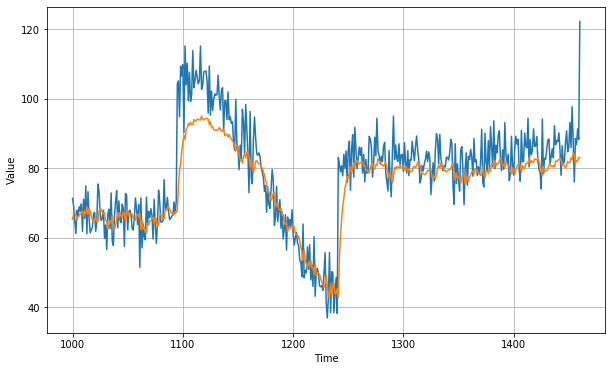

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.819833